In [28]:
from LQGController import *
from matplotlib.gridspec import GridSpec

In [9]:
def linearization_forplot(x):
    TimeConstant = 1 / 0.06  # Torque dynamics coefficient

    # Extract state variables according to the given order
    theta1, dtheta1, tau1, theta2, dtheta2, tau2 = x[:6]

    # Coriolis force
    C = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.sin(theta2),
        dtheta1**2 * a2 * np.sin(theta2)
    ])
    
    # Partial derivatives of C
    dCdte = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.cos(theta2),
        dtheta1**2 * a2 * np.cos(theta2)
    ])
    dCdos = np.array([
        -dtheta2 * 2 * a2 * np.sin(theta2),
        2 * dtheta1 * a2 * np.sin(theta2)
    ])
    dCdoe = np.array([
        (-2 * dtheta1 - 2 * dtheta2) * a2 * np.sin(theta2),
        0
    ])
    
    # Inertia matrix
    M = np.array([
        [a1 + 2 * a2 * np.cos(theta2), a3 + a2 * np.cos(theta2)],
        [a3 + a2 * np.cos(theta2), a3]
    ])
    
    Minv = np.linalg.inv(M)
    
    # Derivative of inertia matrix
    dM = np.array([
        [-2 * a2 * np.sin(theta2), -a2 * np.sin(theta2)],
        [-a2 * np.sin(theta2), 0]
    ])
    
    # Compute acceleration dependencies
    dtheta = np.array([dtheta1, dtheta2])
    tau = np.array([tau1, tau2])

    d_accel_dtheta1 = -Minv @ (dCdos + Bdyn @ np.array([1, 0]))
    d_accel_tau = Minv @ np.array([1, 0])
    d_accel_theta2 = -Minv @ (dM @ Minv @ (tau - C - Bdyn @ dtheta)) - Minv @ dCdte
    d_accel_dtheta2 = -Minv @ (dCdoe + Bdyn @ np.array([0, 1]))
    d_accel_tau2 = Minv @ np.array([0, 1])

    # Construct the Jacobian matrix
    A = np.zeros((2,6))
    # Acceleration contributions
    A[0, 1] = d_accel_dtheta1[0]  # d(dtheta1)/d(dtheta1)
    A[0, 3] = d_accel_theta2[0]
    A[0, 4] = d_accel_dtheta2[0]  # d(dtheta1)/d(dtheta2)
    A[0, 2] = d_accel_tau[0]  # d(dtheta1)/d(tau1)
    A[0, 5] = d_accel_tau2[0]  # d(dtheta1)/d(tau2)

    A[1, 1] = d_accel_dtheta1[1]  # d(dtheta2)/d(dtheta1)
    A[1, 3] = d_accel_theta2[1]
    A[1, 4] = d_accel_dtheta2[1]  # d(dtheta2)/d(dtheta2)
    A[1, 2] = d_accel_tau[1]  # d(dtheta2)/d(tau1)
    A[1, 5] = d_accel_tau2[1]  # d(dtheta2)/d(tau2)


    return A

In [ ]:
def fxstar(x):
    ts,os,taus,te,oe,taue = x
    C = np.array([-oe*(2*os+oe)*a2*np.sin(te),os*os*a2*np.sin(te)])
        
    M = np.array([[a1+2*a2*cos(te),a3+a2*cos(te)],[a3+a2*cos(te),a3]])
        
    return np.linalg.solve(M,(np.array([taus,taue])-Bdyn@np.array([os,oe])-C))

def dfdx(x):
    return linearization_forplot(x)@x

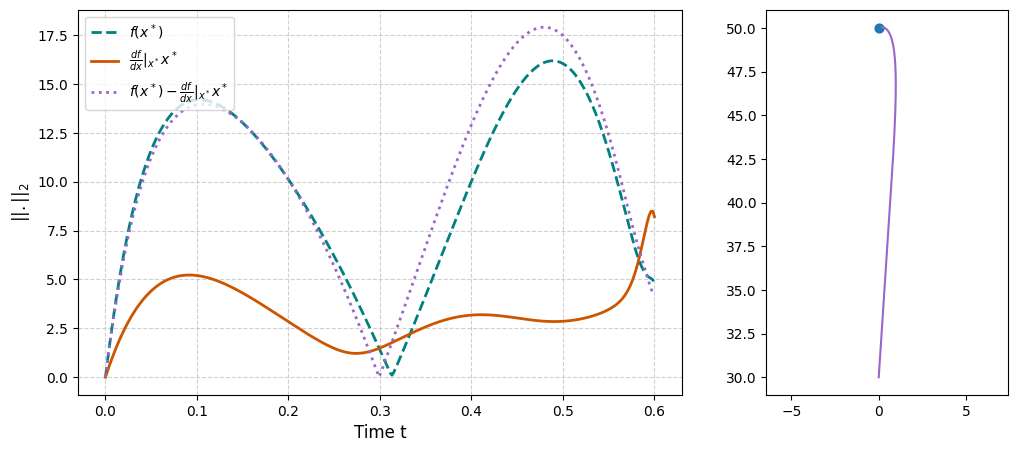

In [39]:
K = 300
X,Y,_,x = BestLQG(plot = False,Num_iter= K,starting_point=[0,30],targets=[0,50])

x = x[:6].T
t = np.linspace(0,.6,K)
norm_fxstar = np.zeros(K) 
norm_dfdx   = np.zeros(K) 
total_norm  = np.zeros(K)

for i in range(K):
    norm_fxstar[i] = np.linalg.norm(fxstar(x[i]))
    norm_dfdx[i]   = np.linalg.norm(dfdx(x[i]))
    total_norm[i]  = np.linalg.norm(fxstar(x[i])-dfdx(x[i]))


fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[2.5, 1])  # First plot 2.5x larger than second

# First subplot (takes more space)
ax1 = fig.add_subplot(gs[0])


ax1.plot(t, norm_fxstar, label='$f(x^*)$', color='#008080', linestyle='dashed', linewidth=2)
ax1.plot(t, norm_dfdx, label=r"$\frac{df}{dx}|_{x^*}x^*$", color='#CC5500', linestyle='solid', linewidth=2)
ax1.plot(t, total_norm, label=r"$f(x^*)-\frac{df}{dx}|_{x^*}x^*$", color='#9966CC', linestyle='dotted', linewidth=2)
ax1.set_xlabel("Time t", fontsize=12)
ax1.set_ylabel(r"$||.||_2$", fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(gs[1])
ax2.plot(X,Y,color = "#9966CC")
ax2.axis("equal")
ax2.scatter([0],[50],s = 40)

plt.savefig("img/Linerror.png",dpi = 400)

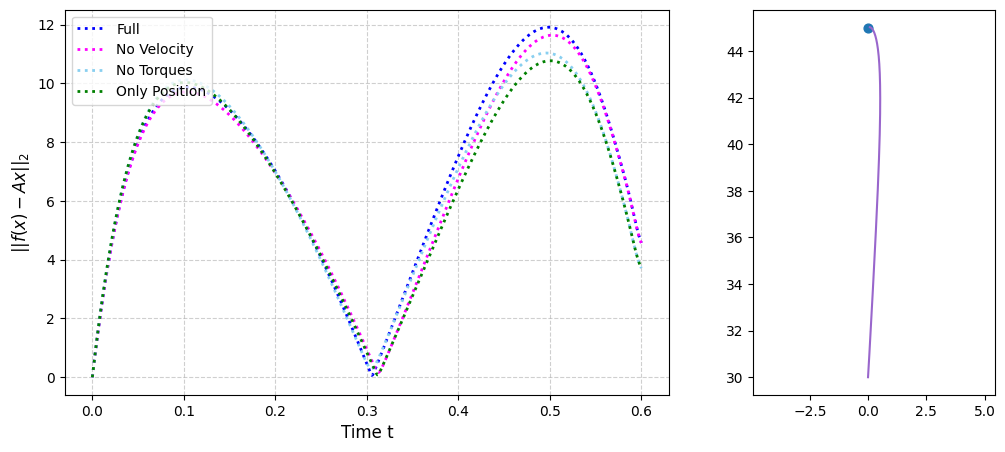

In [51]:
K = 600
X,Y,_,x = BestLQG(plot = False,Num_iter= K,starting_point=[0,30],targets=[0,45])

reelx = x[:6].T
t = np.linspace(0,.6,K)

total_norm  = np.zeros((4,K))

for i in range(K):
    x = np.copy(reelx[i])
    total_norm[0,i]  = np.linalg.norm(fxstar(reelx[i])-dfdx(x))

    x = np.copy(reelx[i])
    x[[1,4]] = [0,0]
    total_norm[1,i]  = np.linalg.norm(fxstar(reelx[i])-dfdx(x))

    x = np.copy(reelx[i])
    x[[2,5]] = [0,0]
    total_norm[2,i]  = np.linalg.norm(fxstar(reelx[i])-dfdx(x))

    x = np.copy(reelx[i])
    x[[1,2,4,5]] = [0,0,0,0]
    total_norm[3,i]  = np.linalg.norm(fxstar(reelx[i])-dfdx(x))


fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 2, width_ratios=[2.5, 1])  # First plot 2.5x larger than second

# First subplot (takes more space)
ax1 = fig.add_subplot(gs[0])


colors = ["blue","magenta", "#89CFF0","green"]
labels = ["Full","No Velocity","No Torques","Only Position"]
for i in range(4):
    ax1.plot(t, total_norm[i], label=labels[i], color=colors[i], linestyle='dotted', linewidth=2)
ax1.set_xlabel("Time t", fontsize=12)
ax1.set_ylabel(r"$||f(x)-Ax||_2$", fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(gs[1])
ax2.plot(X,Y,color = "#9966CC")
ax2.axis("equal")
ax2.scatter([0],[45],s = 40)

In [57]:
def fxstar(x):
    ts,os,taus,te,oe,taue = x
    C = np.array([-oe*(2*os+oe)*a2*np.sin(te),os*os*a2*np.sin(te)])
        
    M = np.array([[a1+2*a2*cos(te),a3+a2*cos(te)],[a3+a2*cos(te),a3]])
        
    vel = np.linalg.solve(M,(np.array([taus,taue])-Bdyn@np.array([os,oe])-C))
    return np.array([os,vel[0],-taus/.06,oe,vel[1],-taue/.06])

def Linearization(dt, x,Bdyn = np.array([[0.05,0.025],[0.025,0.05]])):
    TimeConstant = 1 / 0.06  # Torque dynamics coefficient

    # Extract state variables according to the given order
    theta1, dtheta1, tau1, theta2, dtheta2, tau2 = x[:6]

    # Coriolis force
    C = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.sin(theta2),
        dtheta1**2 * a2 * np.sin(theta2)
    ])
    
    # Partial derivatives of C
    dCdte = np.array([
        -dtheta2 * (2 * dtheta1 + dtheta2) * a2 * np.cos(theta2),
        dtheta1**2 * a2 * np.cos(theta2)
    ])
    dCdos = np.array([
        -dtheta2 * 2 * a2 * np.sin(theta2),
        2 * dtheta1 * a2 * np.sin(theta2)
    ])
    dCdoe = np.array([
        (-2 * dtheta1 - 2 * dtheta2) * a2 * np.sin(theta2),
        0
    ])
    
    # Inertia matrix
    M = np.array([
        [a1 + 2 * a2 * np.cos(theta2), a3 + a2 * np.cos(theta2)],
        [a3 + a2 * np.cos(theta2), a3]
    ])
    
    Minv = np.linalg.inv(M)
    
    # Derivative of inertia matrix
    dM = np.array([
        [-2 * a2 * np.sin(theta2), -a2 * np.sin(theta2)],
        [-a2 * np.sin(theta2), 0]
    ])
    
    # Compute acceleration dependencies
    dtheta = np.array([dtheta1, dtheta2])
    tau = np.array([tau1, tau2])

    d_accel_dtheta1 = -Minv @ (dCdos + Bdyn @ np.array([1, 0]))
    d_accel_tau = Minv @ np.array([1, 0])
    d_accel_theta2 = -Minv @ (dM @ Minv @ (tau - C - Bdyn @ dtheta)) - Minv @ dCdte
    d_accel_dtheta2 = -Minv @ (dCdoe + Bdyn @ np.array([0, 1]))
    d_accel_tau2 = Minv @ np.array([0, 1])

    # Construct the Jacobian matrix
    A = np.zeros((6,6))

    # Assign known structure
    A[0, 1] = 1  # d(theta1)/d(dtheta1)
    A[3, 4] = 1  # d(theta2)/d(dtheta2)

    # Acceleration contributions
    A[1, 1] = d_accel_dtheta1[0]  # d(dtheta1)/d(dtheta1)
    A[1, 3] = d_accel_theta2[0]
    A[1, 4] = d_accel_dtheta2[0]  # d(dtheta1)/d(dtheta2)
    A[1, 2] = d_accel_tau[0]  # d(dtheta1)/d(tau1)
    A[1, 5] = d_accel_tau2[0]  # d(dtheta1)/d(tau2)

    A[4, 1] = d_accel_dtheta1[1]  # d(dtheta2)/d(dtheta1)
    A[4, 3] = d_accel_theta2[1]
    A[4, 4] = d_accel_dtheta2[1]  # d(dtheta2)/d(dtheta2)
    A[4, 2] = d_accel_tau[1]  # d(dtheta2)/d(tau1)
    A[4, 5] = d_accel_tau2[1]  # d(dtheta2)/d(tau2)

    # Torque dynamics
    A[2, 2] = -TimeConstant
    A[5, 5] = -TimeConstant


    A = np.identity(6)+dt*A
    return A

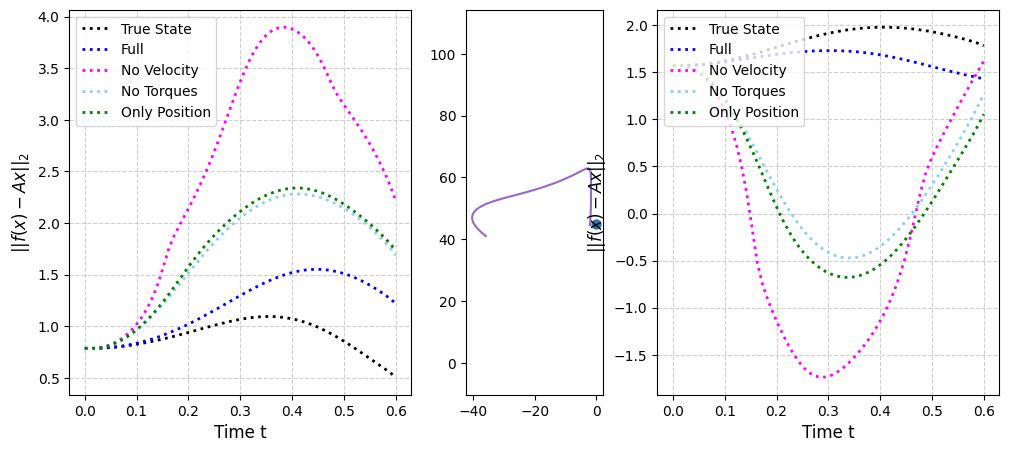

In [71]:
from FLController import*
K = 60
X,Y,flu = Feedback_Linearization(plot = False,Num_iter= K,starting_point=[0,30],targets=[0,45],Showu=True)


reelx = np.array([pi/4,0,0,pi/2,0,0])
x1 = np.array([pi/4,0,0,pi/2,0,0])
x2= np.array([pi/4,0,0,pi/2,0,0])
x3 = np.array([pi/4,0,0,pi/2,0,0])
x4= np.array([pi/4,0,0,pi/2,0,0])
t = np.linspace(0,.6,K)

total_norm  = np.zeros((5,K,6))
dt = .1
for i in range(K):
    u = flu[i-1]/6 if i>0 else np.array([0,0])
    reelx += dt*fxstar(reelx)+ np.array([0,0,u[0],0,0,u[1]])

    A= Linearization(dt,x1)
    x1 = A@x1 + np.array([0,0,u[0],0,0,u[1]])

    total_norm[4,i]  = reelx
    total_norm[0,i]  = x1

    x=np.copy(x2)
    x[[1,4]] = [0,0]
    A= Linearization(dt,x)
    x2 = A@x2 + np.array([0,0,u[0],0,0,u[1]])

    total_norm[1,i]  = x2


    x = np.copy(x3)
    x[[2,5]] = [0,0]
    A= Linearization(dt,x)
    x3 = A@x3 + np.array([0,0,u[0],0,0,u[1]])
    total_norm[2,i]  = x3

    x = np.copy(x4)
    x[[1,2,4,5]] = [0,0,0,0]
    A= Linearization(dt,x)
    x4 = A@x4 + np.array([0,0,u[0],0,0,u[1]])
    total_norm[3,i]  = x4


fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[2.5, 1,2.5])  # First plot 2.5x larger than second

# First subplot (takes more space)
ax1 = fig.add_subplot(gs[0])


colors = ["black","blue","magenta", "#89CFF0","green"]
labels = ["True State","Full","No Velocity","No Torques","Only Position"]
for i in range(5):
    ax1.plot(t, total_norm[i,:,0], label=labels[i], color=colors[i], linestyle='dotted', linewidth=2)
ax1.set_xlabel("Time t", fontsize=12)
ax1.set_ylabel(r"$||f(x)-Ax||_2$", fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)

ax2 = fig.add_subplot(gs[1])
X,Y = ToCartesian(total_norm[4],at3=True)
ax2.plot(X,Y,color = "#9966CC")
ax2.axis("equal")
ax2.scatter([0],[45],s = 40)

ax1 = fig.add_subplot(gs[2])


colors = ["black","blue","magenta", "#89CFF0","green"]
labels = ["True State","Full","No Velocity","No Torques","Only Position"]
for i in range(5):
    ax1.plot(t, total_norm[i,:,3], label=labels[i], color=colors[i], linestyle='dotted', linewidth=2)
ax1.set_xlabel("Time t", fontsize=12)
ax1.set_ylabel(r"$||f(x)-Ax||_2$", fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)